In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
GITHUB_CDN = "https://raw.githubusercontent.com/realamirhe/github-stargazer"
js_repo_urls = map(
    lambda idx: f"{GITHUB_CDN}/master/data/js-{idx}.csv",
    range(1, 10)
)

datas = pd.concat(list(map(pd.read_csv, js_repo_urls)))
datas = datas.select_dtypes(exclude=['object'])
datas = datas.drop(columns=['Unnamed: 0', 'score'], axis=1)
datas = datas.reset_index()

In [17]:
y = datas['stargazers_count']
X = datas.drop(columns=['stargazers_count', 'index', 'watchers', 'watchers_count'])
X = X.replace({ False: 0, True: 1 })

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   private                      900 non-null    int64
 1   owner.public_repos           900 non-null    int64
 2   owner.public_gists           900 non-null    int64
 3   owner.followers              900 non-null    int64
 4   owner.following              900 non-null    int64
 5   fork                         900 non-null    int64
 6   forks                        900 non-null    int64
 7   size                         900 non-null    int64
 8   has_issues                   900 non-null    int64
 9   has_projects                 900 non-null    int64
 10  has_downloads                900 non-null    int64
 11  has_wiki                     900 non-null    int64
 12  has_pages                    900 non-null    int64
 13  has_discussions              900 non-null    int64

In [18]:
print("Data:\n", X.head(1).squeeze())
print("target:\t\t\t\t", y[0])

Data:
 private                            0
owner.public_repos                64
owner.public_gists                62
owner.followers                23302
owner.following                   11
fork                               0
forks                            540
size                            7954
has_issues                         1
has_projects                       1
has_downloads                      1
has_wiki                           1
has_pages                          0
has_discussions                    0
forks_count                      540
archived                           0
disabled                           0
open_issues_count                 30
allow_forking                      1
is_template                        0
web_commit_signoff_required        0
Name: 0, dtype: int64
target:				 1962


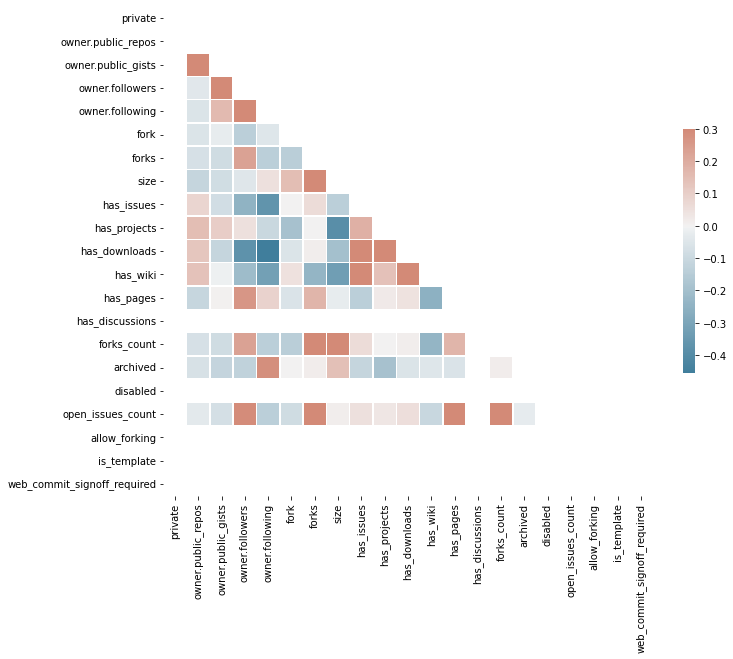

In [19]:
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

[]

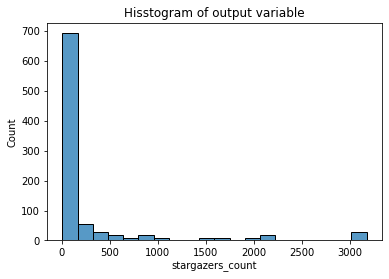

In [20]:
ax = sns.histplot(x=y, bins=20)
ax.set_title('Hisstogram of output variable')
plt.plot()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=42
)

In [22]:
#x_pca_train=x_train-np.mean(x_train)
#x_pca_test=x_test-np.mean(x_train)
pca=PCA(n_components=1)
pca.fit(X_train)

print('sum of explained variance ratio PC=1', np.sum(pca.explained_variance_ratio_[:1]))
print('sum of explained variance ratio PC=2', np.sum(pca.explained_variance_ratio_[:2]))
X_pca = pca.transform(X)

sum of explained variance ratio PC=1 0.8849304374661274
sum of explained variance ratio PC=2 0.8849304374661274


## Linear Regression

In [23]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test,y_test)

0.9271528255655072

In [24]:
from sklearn.model_selection import cross_val_score

reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=5)

print(
    "[Normal]: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)

reg = LinearRegression()
scores = cross_val_score(reg, X_pca, y, cv=5)
print(
    "[PCA]: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)

[Normal]: 0.93 accuracy with a standard deviation of 0.01
[PCA]: 0.11 accuracy with a standard deviation of 0.04


In [25]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

# TODO: the score is calculcated wrongly!
print("Linear Regression R2 score: ",reg.score(X_test, y_test))
print("Linear Regression MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("Linear Regression MAE: ",metrics.mean_absolute_error(y_test,y_pred))

Linear Regression R2 score:  0.9271528255655072
Linear Regression MSE:  36704.056795799195
Linear Regression MAE:  98.27249653128393


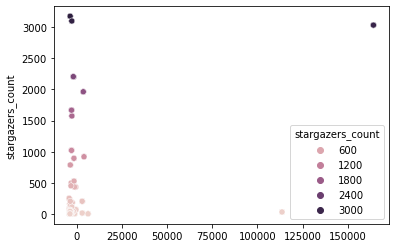

In [26]:
sns.scatterplot(x=X_pca.flatten(), y=y, hue=y)
plt.show()

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by SVM')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

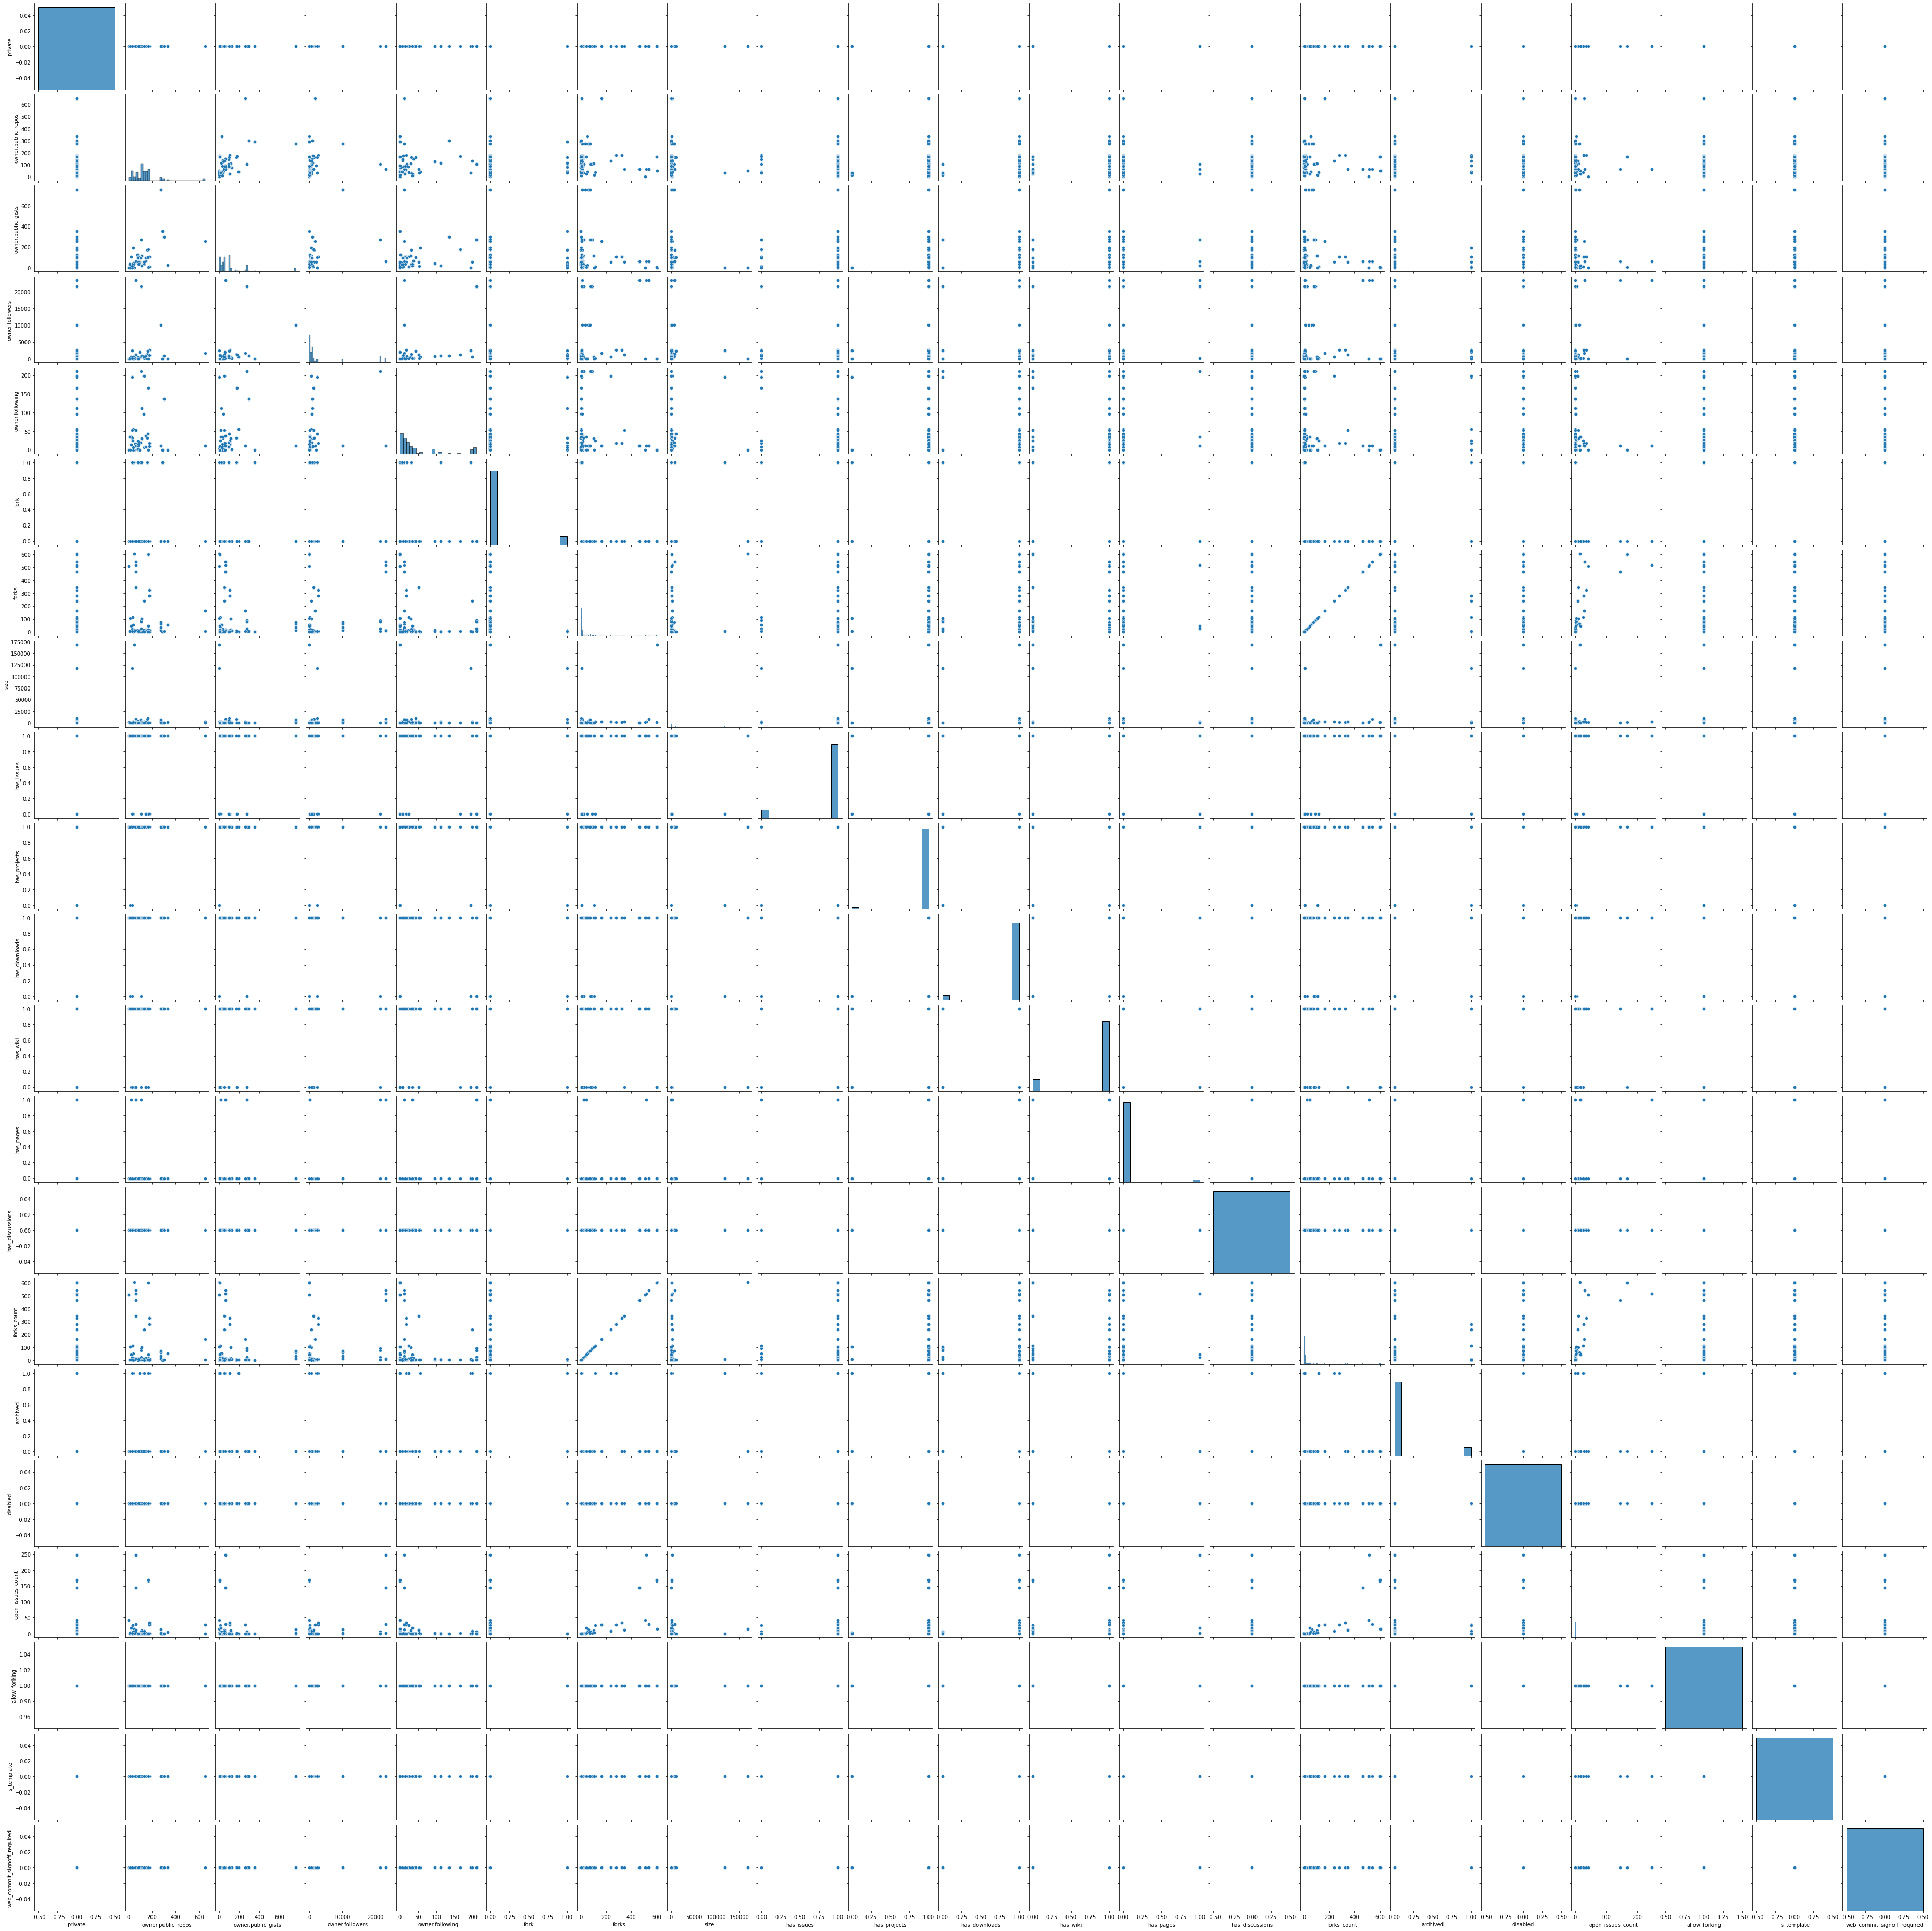

In [43]:
sns.pairplot(X)

## Best Features

In [27]:
feature_names = X.columns
accuracy = []
best_feature_names = []
N = X.shape[1]
for i in range(N-1):
  reg = LinearRegression()
  sfs = SequentialFeatureSelector(reg, n_features_to_select=i+1)
  sfs.fit(X_train, y_train)
  best_feature_names.append(feature_names[sfs.get_support()])
  accuracy.append(cross_val_score(LinearRegression(), X, y, cv=5))

In [40]:
for feat, acc in zip(best_feature_names, accuracy):
  features = ", ".join(feat.to_list())
  print(f"selected features: {features}\nMake the accuracy reaches N({acc.mean()}, {scores.std()})")
# plt.bar(np.arange(N-1)+1,accuracy)
# plt.xlabel('Number of features')
# plt.ylabel('Score')
# plt.title('Score-Best Subset of Features')

selected features: forks
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: forks, open_issues_count
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: forks, size, open_issues_count
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: owner.following, forks, size, open_issues_count
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: owner.following, forks, size, has_wiki, open_issues_count
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: owner.following, forks, size, has_issues, has_wiki, open_issues_count
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: owner.public_gists, owner.following, forks, size, has_issues, has_wiki, open_issues_count
Make the accuracy reaches N(0.9277451414747733, 0.0373989232935378)
selected features: owner.public_gists, owner.following, forks, 

## SVM

In [47]:
from sklearn.svm import SVR

pca=PCA(n_components=1)
x_pca=pca.fit(X_train).transform(X)

model_svr=SVR(kernel="linear")
model_svr.fit(X_train, y_train)
y_pred=model_svr.predict(X_test)
print("SVM R2 score:", model_svr.score(X_test, y_test))
print("SVM MSE:", metrics.mean_squared_error(y_test, y_pred))
print("SVM MAE:", metrics.mean_absolute_error(y_test, y_pred))

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by SVM')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

SVM R2 score: 0.8768052876254382
SVM MSE: 62071.669286283664
SVM MAE: 111.19211150149913


## Decision Tree

In [54]:
from sklearn.tree import DecisionTreeRegressor

dt_ergressor = DecisionTreeRegressor(criterion="squared_error")
dt_ergressor.fit(X_train, y_train)
y_pred = dt_ergressor.predict(X_test)
print("Decision Tree R2 score: ",dt_ergressor.score(X_test, y_test))
print("Decision Tree MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("Decision Tree MAE: ",metrics.mean_absolute_error(y_test, y_pred))
scores = cross_val_score(dt_ergressor, X, y, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")


# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by DT')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

Decision Tree R2 score:  0.9999999998277155
Decision Tree MSE:  8.680555555555556e-05
Decision Tree MAE:  0.0006944444444444445
5-Fold accuracy N(0.9999999519697009, 9.5216169925704e-08)


## KNN

In [55]:
from sklearn.neighbors import KNeighborsRegressor

knn_ergressor = KNeighborsRegressor(n_neighbors=5)
knn_ergressor.fit(X_train,y_train)
y_pred = knn_ergressor.predict(X_test)
print("KNN R2 score: ",knn_ergressor.score(X_test,y_test))
print("KNN MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("KNN MAE: ",metrics.mean_absolute_error(y_test,y_pred))

scores = cross_val_score(knn_ergressor, X, y, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by KNN')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

KNN R2 score:  0.9993279301954245
KNN MSE:  338.62244444444497
KNN MAE:  3.1255555555555614
5-Fold accuracy N(0.9999999523074935, 9.538501286598943e-08)


## Multilayer Perceptron

In [58]:
from sklearn.neural_network import MLPRegressor
params = {
  "hidden_layer_sizes":(300,100,50),
  "activation":"relu",
  "solver":"lbfgs",
  "learning_rate":"adaptive", 
  "learning_rate_init":0.3,
}
MLP_ergressor = MLPRegressor(**params)
MLP_ergressor.fit(X_train,y_train)
y_pred = MLP_ergressor.predict(X_test)
print("MLP R2 score: ",MLP_ergressor.score(X_test,y_test))
print("MLP MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("MLP MAE: ",metrics.mean_absolute_error(y_test,y_pred))

# MLP_ergressor = MLPRegressor(**params, max_iter=100)
# scores = cross_val_score(MLP_ergressor, X, y, cv=5)
# print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by MLP')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

MLP R2 score:  0.9222548105690695
MLP MSE:  39171.92218675658
MLP MAE:  97.89229874144172


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## AdaBoost Regressor

In [60]:
from sklearn.ensemble import AdaBoostRegressor

AdaBoost_ergressor = AdaBoostRegressor(n_estimators=50)
AdaBoost_ergressor.fit(X_train,y_train)
y_pred = AdaBoost_ergressor.predict(X_test)
print("AdaBoost R2 score:", AdaBoost_ergressor.score(X_test, y_test))
print("AdaBoost MSE:", metrics.mean_squared_error(y_test, y_pred))
print("AdaBoost MAE:", metrics.mean_absolute_error(y_test, y_pred))

scores = cross_val_score(AdaBoost_ergressor, X, y, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by AdaBoost')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

AdaBoost R2 score: 0.9847233581037668
AdaBoost MSE: 7697.137688060203
AdaBoost MAE: 71.25368706052771
5-Fold accuracy N(0.983239070850917, 0.0035333620839793326)


## Bagging (Ensemble Learning)

In [61]:
from sklearn.ensemble import BaggingRegressor

bagging_ergressor = BaggingRegressor(n_estimators=50)
bagging_ergressor.fit(X_train,y_train)
y_pred = bagging_ergressor.predict(X_test)
print("Bagging (Ensemble Learning) R2 score:", bagging_ergressor.score(X_test, y_test))
print("Bagging (Ensemble Learning) MSE:", metrics.mean_squared_error(y_test, y_pred))
print("Bagging (Ensemble Learning) MAE:", metrics
      .mean_absolute_error(y_test, y_pred))
scores = cross_val_score(bagging_ergressor, X, y, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by Bagging (Ensemble Learning)')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

Bagging (Ensemble Learning) R2 score: 0.9997155231299418
Bagging (Ensemble Learning) MSE: 143.33370205174117
Bagging (Ensemble Learning) MAE: 2.048948878898884
5-Fold accuracy N(0.999999922567454, 8.319171495099926e-08)


## XGBoost

In [63]:
import xgboost as xgb

xgb_ergressor = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_ergressor.fit(X_train, y_train)
y_pred = xgb_ergressor.predict(X_test)
print("XGBoost R2 score:", xgb_ergressor.score(X_test, y_test))
print("XGBoost MSE:", metrics.mean_squared_error(y_test, y_pred))
print("XGBoost MAE:", metrics.mean_absolute_error(y_test, y_pred))

scores = cross_val_score(xgb_ergressor, X, y, cv=5)
print(f"5-Fold accuracy N({scores.mean()}, {scores.std()})")

# plt.figure(figsize=(10,5))
# plt.title('Dimention reduced and predicted point by XGBoost')
# plt.xlim((-5000,0))
# plt.ylim((-50,300))
# plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
# plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
# plt.legend(['Real','Predicted'])
# plt.xlabel('Reduced features(By PCA)')
# plt.ylabel('Stargazer')
# plt.show()

[15:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost R2 score: 0.9995730305170855
XGBoost MSE: 215.12862060368204
XGBoost MAE: 10.216613364219665
[15:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5-Fold accuracy N(0.9996715127381502, 2.3579006703737038e-05)
